In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests

from decode_fish.funcs.merfish_eval import *
from starfish import data
import pprint

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [4]:
bench_df, code_ref, targets = get_benchmark()

13832


In [5]:
istdeco_df = get_istdeco()

156501


In [17]:
pred_df = pd.read_csv('../data/results/MERFISH/exp_ci_1.csv')
pred_df = pd.read_csv('../data/results/MERFISH/exp_ci14_ct04.csv')

pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
len(pred_df)

46096

In [18]:
res_df = get_code_from_ints(pred_df, code_ref, targets, vcorrcoef)

100%|████████████████████████████████████████████████████| 46096/46096 [00:05<00:00, 8849.60it/s]


In [19]:
res_sub = res_df.nsmallest(17500, 'code_err')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

In [13]:
matches, bench_match = match_bench(res_sub, bench_sub)

[88.35715063418559, 89.075465562714, 0.0]
Recall: 0.755
Precision: 0.596
Jaccard: 49.919
RMSE_vol: 82.982
Eff_3d: 34.964
FN: 3378.0 FP: 7078.0
Num. matches: 10422.000
Shift: 1.53,1.47,0.00


In [20]:
matches, bench_match = match_bench(res_sub, bench_sub)

[89.27179359787281, 89.40575152382911, 0.0]
Recall: 0.744
Precision: 0.587
Jaccard: 48.821
RMSE_vol: 82.698
Eff_3d: 34.205
FN: 3532.0 FP: 7232.0
Num. matches: 10268.000
Shift: 1.52,1.65,0.00


In [21]:
bench_counts = DF(data=None, index=targets)
bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
bench_counts['Bench_all'] = bench_sub.groupby('gene')['gene'].count()
bench_counts = bench_counts.fillna(0)

fps = res_sub.loc[~res_sub['loc_idx'].isin(matches['pred_idx'])]
fns = bench_match.loc[~bench_match['loc_idx'].isin(matches['tar_idx'])]

bench_counts['Res_fp'] = fps.groupby('gene')['gene'].count()
bench_counts['Res_fns'] = fns.groupby('gene')['gene'].count()
bench_counts=bench_counts.fillna(0)

13800 17500


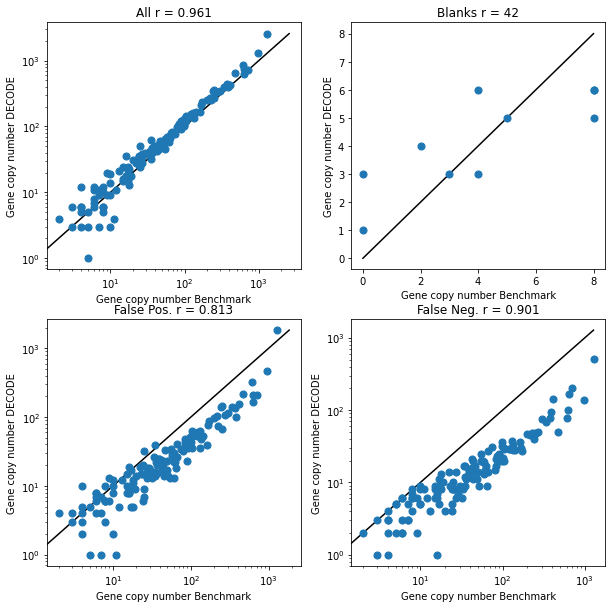

In [22]:
print(len(bench_sub), len(res_sub))

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=True)

binds = []
for i,g in enumerate(targets):
    if 'Blank' in g:
        binds.append(g)
        
plt.subplot(222)
plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False)

plt.subplot(223)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=True)

plt.subplot(224)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fns'].values, 'False Neg.', log=True)

In [27]:
from decode_fish.funcs.visualization import *
par_dict = {'res_df_ce':[res_df, 'code_err', True],
            'res_df_cs':[res_df, 'comb_sig', True],
            'istdeco':[istdeco_df, 'quality', False],
            'bench':[bench_df, 'total_magnitude', False]}

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]

(0.0, 24000.0)

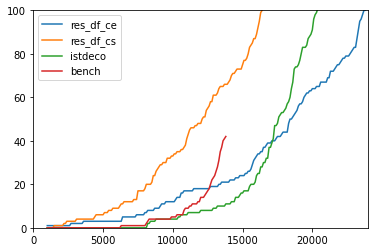

In [28]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 24000)

In [23]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

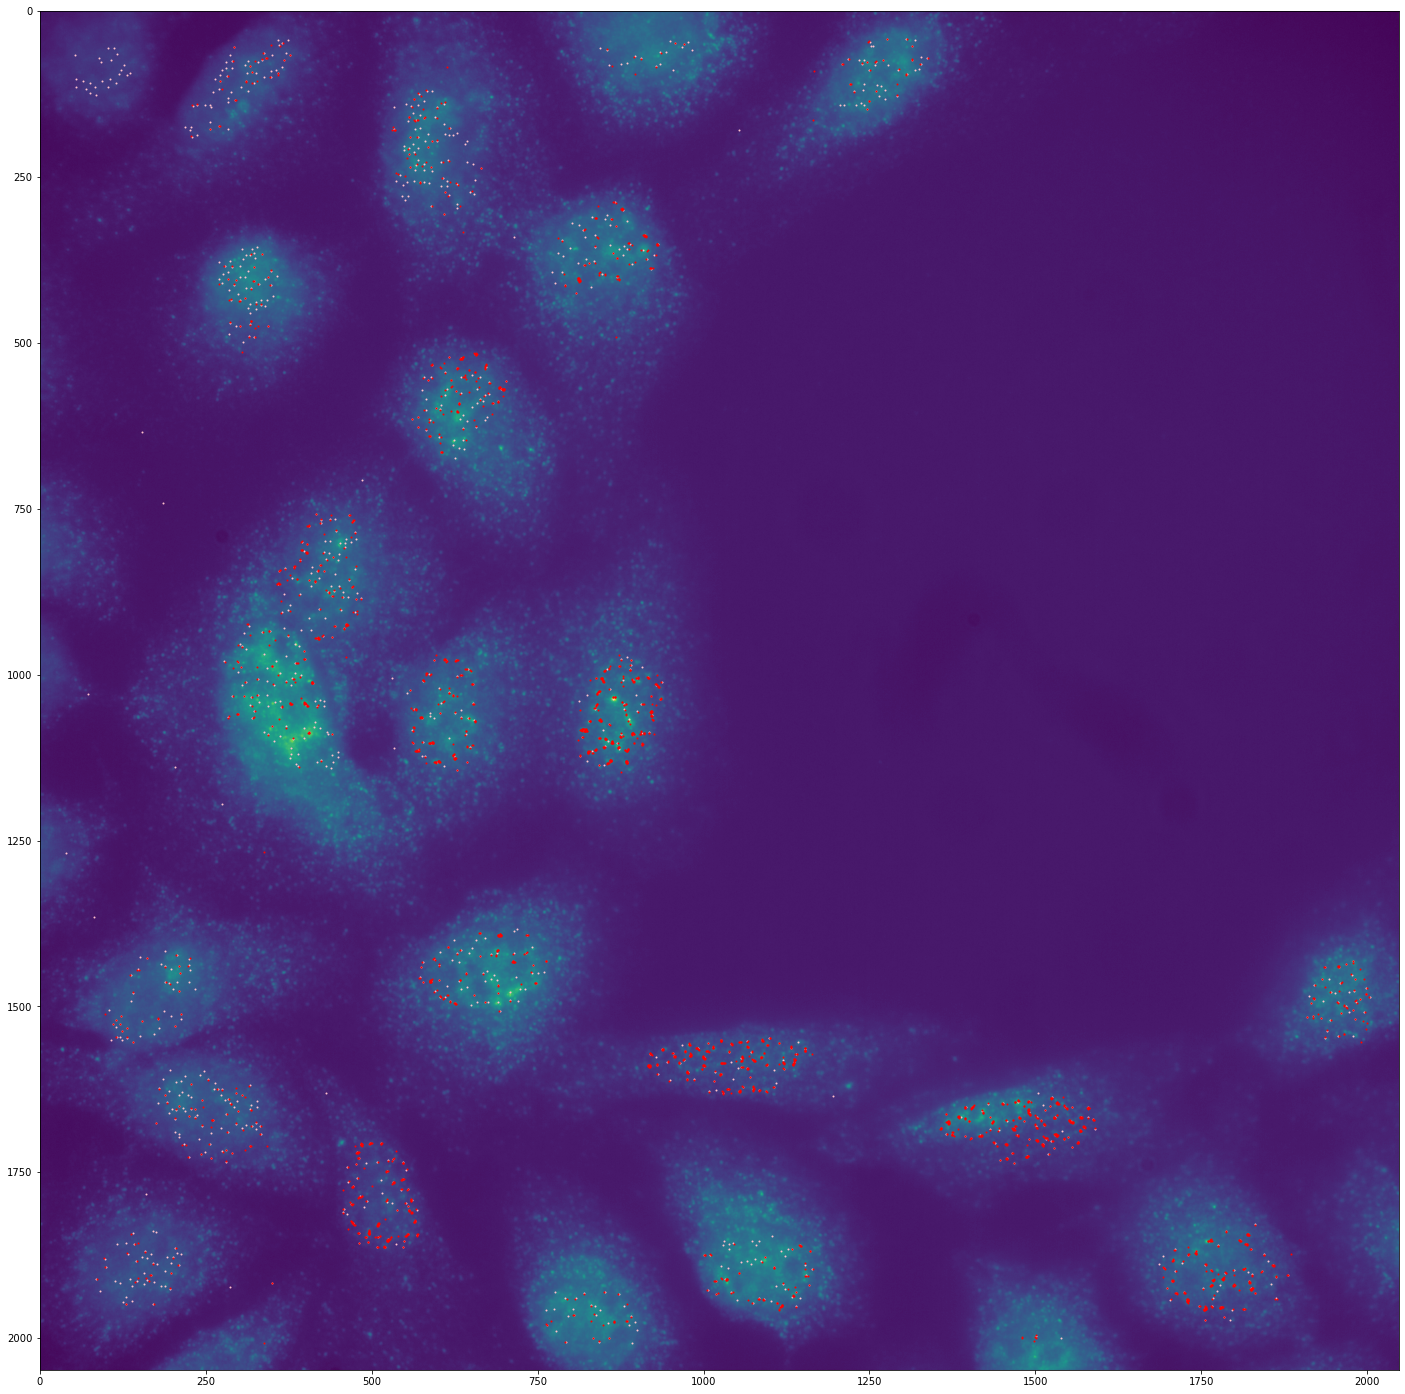

In [24]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_sub)[res_sub['gene']=='MALAT1']
bench_px = nm_to_px(bench_match)[bench_match['gene']=='MALAT1']

plt.figure(figsize=(25,25))
plt.imshow(img[0,0])

plt.scatter(bench_px['x'],bench_px['y'], color='pink', s=1.)
plt.scatter(preds_px['x'],preds_px['y'], color='red', s=1.0)

In [29]:
img_stack = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff')[:,0]

In [34]:
def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    tot_size = torch.Size([1, 16, size_xy*2+1, size_xy*2+1])
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [25]:
# Random predictions 

ind = np.random.randint(0, len(res_sub))
print(ind)
ind = 17048

b_loc = nm_to_px(res_sub.iloc[ind])
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if b_loc['code'][i] else 'white'
    plt.scatter([10],[10], color=color)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')

NameError: name 'res_sub' is not defined

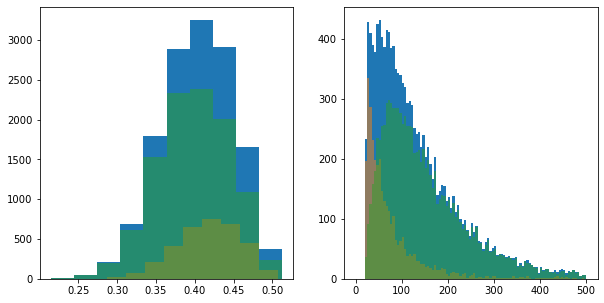

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_ = plt.hist(bench_match['av_distance'], density=False)
_ = plt.hist(bench_match['av_distance'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5)
_ = plt.hist(bench_match['av_distance'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5)

plt.subplot(122)
_ = plt.hist(bench_match['total_magnitude'], density=False, bins=np.linspace(0,500,101))
_ = plt.hist(bench_match['total_magnitude'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5)
_ = plt.hist(bench_match['total_magnitude'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5)

In [36]:
fn_inds = fns['loc_idx'].values
# btps = bench_match.loc[bench_match['loc_idx'].isin(matches['tar_idx'])]
# fn_inds = btps['loc_idx'].values

,Unnamed: 0,barcode,barcode_id,fov_id,total_magnitude,area,is_exact,error_bit,error_dir,av_distance,x,y,wx,wy,gene,code,frame_idx,loc_idx,int,z
3034,12430,1010000000000110,49,0,66.170219,9,0,2,0,0.400019,1117.047144,1646.129023,1117.792847,1647.254639,RNF169,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]",0,3034,66.170219,0.5


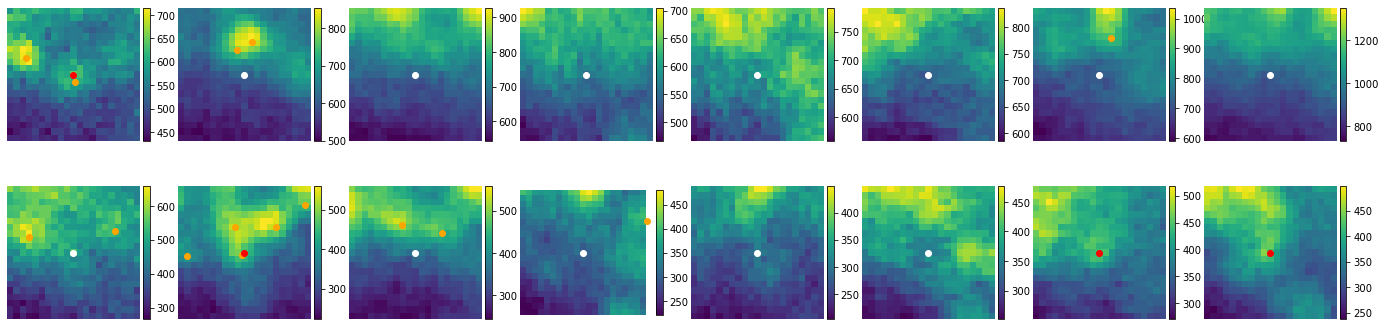

In [37]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]
# ind = 1607

b_loc = nm_to_px(bench_match[bench_match['loc_idx'] == ind]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(24,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    im = plt.imshow(vol[0,i])
    plt.axis('off')
    add_colorbar(im)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')
    color = 'red' if b_loc['code'][i] else 'white'
    plt.scatter([10],[10], color=color)

In [44]:
blank_df = res_sub[res_sub['gene'].str.contains('Blank')]
blank_df = blank_df.sort_values('logdist', ascending=False)

In [61]:
blank_df.groupby('cc')['cc'].count().values / res_sub.groupby('cc')['cc'].count().values*100

array([2.34814671, 0.35903062, 2.15889465])

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig,comb_sig,group_idx,code,cc,rmses,logdist,gene
31040,36361,0,209.70791,552.50746,0.5,0.861657,6.397343,0.619625,29.323174,20.414253,100.0,1.061913,9485,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,6.431063,-9.050423,Blank-9


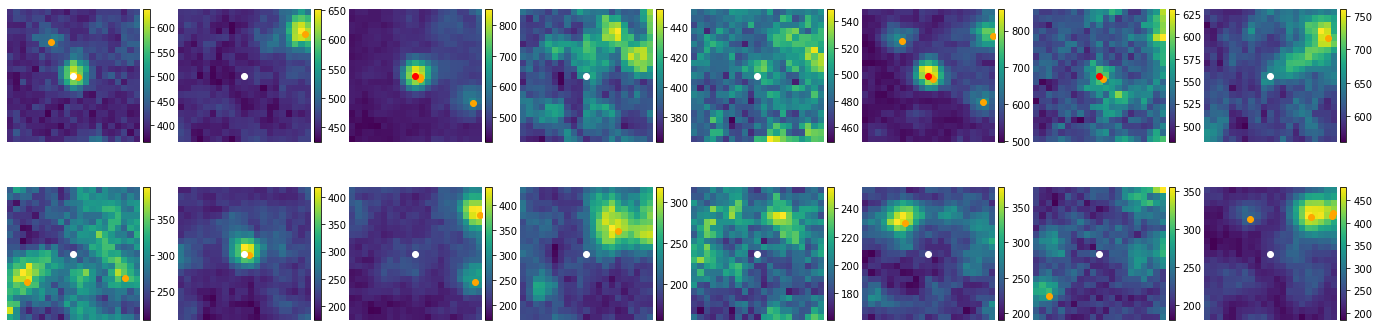

In [51]:
b_loc = nm_to_px(blank_df).iloc[2]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(24,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    im = plt.imshow(vol[0,i])
    plt.axis('off')
    add_colorbar(im)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')
    color = 'red' if b_loc['code'][i] else 'white'
    plt.scatter([10],[10], color=color)

In [35]:
b_m = bench_match[bench_match['loc_idx'] == m['tar_idx']]
p_m = res_df_filt[res_df_filt['loc_idx'] == m['pred_idx']]

NameError: name 'm' is not defined

In [ ]:
display(p_m)
display(b_m)

In [ ]:
# for c in range(2):
#     for i in range(8):

#         img = load_tiff_image(image_paths[i])
#         preds_px = nm_to_px(pred_df[pred_df['frame_idx']==(i+c*8)])
#         plt.figure(figsize=(25,25))
#         plt.imshow(img[c,0])
#         plt.title('i'+str(i)+'c'+str(c))

#         plt.scatter(preds_px['x'],preds_px['y'], color='red', s=1.5)
#         plt.show()

In [ ]:
non_targeted_names = [ f'Blank-{i+1}' for i in range(10)]

In [ ]:
# How many blank-genes (false positives) do we accept?
non_targeted_names = [ f'Blank-{i+1}' for i in range(10)]

# Download benchmark
bench_raw = pd.read_csv('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv',\
                    dtype={'barcode': object})

# Filter benchmark

ns = []

for i in range(1,101):
    bench = bench_raw[bench_raw['area'] > 3]
    thresh = bench[bench['gene'].isin(non_targeted_names)]['total_magnitude'].nlargest(i).iloc[-1]
    bench = bench[bench['total_magnitude'] > thresh]
    ns.append(len(bench))

In [ ]:
plt.plot(ns)